# CNN MobileNet V2

Ce modèle avancée de Deep Learning utilise le modèle [MobileNet V2](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2) pour prédire la catégorie des images.

## Setup

La cellule ci-dessous permet de définir les constantes utilisées dans ce notebook.

In [1]:
import os
import datetime

# Define our images size
IMG_SIZE = 224
# Number of categories we have
NO_OF_OUTPUT_CLASSES = 27
# Batch size used during training and seed for shuffling
BATCH_SIZE = 96
SEED = 12345

# True to add data augmentation layers
DO_DATA_AUGMENTATION = True

# Define if we are running the model locally or on Google Colab
# This allow the usage af all the RAM available locally, but not
# on Colab to avoid crashes.
# True for local run, False for Google Colab
IS_LOCAL = True

if IS_LOCAL:
    import src.data.data as data

    # Image input directories
    TRAIN_DIR = data.get_output_dir(IMG_SIZE, IMG_SIZE, True, False, "train")
    TEST_DIR = data.get_output_dir(IMG_SIZE, IMG_SIZE, True, False, "test")

    # Checkpoint directory and paths
    CHECKPOINT_DIR = os.path.join(
        "data", "models", "cnn_mobilenetv2_keras")
    CHECKPOINT_PATH = os.path.join(
        CHECKPOINT_DIR, "cp_{val_loss:.2f}-{val_accuracy:.2f}-.ckpt")

    # Path to the history CSV file to store training metrics
    HIST_CSV_PATH = os.path.join(CHECKPOINT_DIR, "history.csv")

    # Define where to store training logs
    LOG_DIR = os.path.join(CHECKPOINT_DIR, "logs", "fit")
    LOG_DATA = os.path.join(
        LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    # Contants used only for image generation
    # Define the dataset size
    TRAIN_SIZE = 0.8
    TEST_SIZE = 0.2
    # Number of threads to use with images conversion
    NB_THREADS = 16

else:
    PATH_TO_IMG_ZIP = "/content/drive/MyDrive/fev23_bds_rakuten/Modèles/cropped_w224_h224_ratio_colors.zip"

    TRAIN_DIR = "/content/data/images/cropped_w224_h224_ratio_colors/train"
    TEST_DIR = "/content/data/images/cropped_w224_h224_ratio_colors/test"

    CHECKPOINT_DIR = "/content/drive/MyDrive/fev23_bds_rakuten/Modèles/cnn_mobilenetv2/"
    CHECKPOINT_PATH = CHECKPOINT_DIR + \
        "cp_{val_loss:.2f}-{val_accuracy:.2f}-.ckpt"

    HIST_CSV_PATH = CHECKPOINT_DIR + "history.csv"

    # Define where to store training logs
    LOG_DIR = os.path.join(CHECKPOINT_DIR, "logs", "fit")
    LOG_DATA = os.path.join(
        LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## Chargement des jeux de données et déclaration de la couche d'augmentation

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

if "2.9" in tf.version.VERSION:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="categorical")

    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="categorical")
else:
    (train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2,
        subset="both",
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical")


# if IS_LOCAL:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2023-04-19 10:30:58.589371: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-19 10:30:58.722751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 10:30:59.352119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 67932 files belonging to 27 classes.
Using 54346 files for training.
Using 13586 files for validation.


2023-04-19 10:31:03.158406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 10:31:03.240164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 10:31:03.240363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 10:31:03.242088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 10:31:03.242236: I tensorflow/compile

Found 16984 files belonging to 27 classes.


## Chargement et compilation du modèle.

In [22]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.train import latest_checkpoint
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential, regularizers

# Tensorflow supports GPU on Windows until version 2.10
# However, this version produces a lot of warning when using
# data augmentation layer. Also, we have different imports
if ("2.10" in tf.version.VERSION):
    print("Running Tensorflow 2.10, set logging to errors only to avoid warning message flooding from data augmentation layers.")
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    from tensorflow.keras.optimizers import SGD
elif ("2.9" in tf.version.VERSION):
    print("Running Tensorflow 2.9")
    from tensorflow.keras.optimizers import SGD
else:
    print(f"Running {tf.version.VERSION}")
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    from tensorflow.keras.optimizers.legacy import SGD

mobilenet_layers = tf.keras.applications.MobileNetV2(
    include_top=False,  # Do not include the ImageNet classifier at the top
    weights="imagenet",  # Load weights pre-trained on ImageNet
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
# Freeze the base model
mobilenet_layers.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Input")

if DO_DATA_AUGMENTATION:
    x = Sequential([
        layers.RandomFlip("horizontal_and_vertical", name="RandomFlip"),
        layers.RandomRotation(0.2, name="RandomRotation"),
        layers.RandomTranslation(
            height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3),
            name="RandomTranslation")
    ], name="Augmentations")(inputs)

    # Rescale the pixels to have values between 0 and 1 to meet MobileNet requirements
    x = layers.Rescaling(1./255, name="Rescaling")(x)

else:
    # Rescale the pixels to have values between 0 and 1 to meet MobileNet requirements
    x = layers.Rescaling(1./255, name="Rescaling")(inputs)

# Run in inference mode to be safe when we unfreeze the base model for fine-tuning
x = mobilenet_layers(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(rate=0.2, name="Dropout")(x)

outputs = layers.Dense(NO_OF_OUTPUT_CLASSES,
                       name="Output")(x)
model = tf.keras.Model(inputs, outputs, name="RakutenImageNet")

model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.compile(
    optimizer=SGD(learning_rate=0.005, momentum=0.9),
    loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])

model.summary()

latest = latest_checkpoint(CHECKPOINT_DIR)
if (latest is not None):
    print("Loading checkpoint", latest)
    model.load_weights(latest)
else:
    print("No checkpoint to load")

# Callbacks called between each epoch
cp_callbacks = [
    # Stop the training when there is no improvement in val_accuracy for x epochs
    EarlyStopping(monitor='val_accuracy', patience=10),
    # Save a checkpoint
    ModelCheckpoint(CHECKPOINT_PATH,
                    save_best_only=True,
                    mode="max",
                    monitor="val_accuracy",
                    save_weights_only=True,
                    verbose=1),
    # Insert the metrics into a CSV file
    CSVLogger(HIST_CSV_PATH, separator=',', append=True),
    # Log information to display them in TensorBoard
    TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
]

# The numbers bellow were found following the execution of the previous cell. Somehow, I didn't find a way to store them in a variable without going through the whole data set.
steps_per_epoch = 54346 // BATCH_SIZE
validation_steps = 13586 // BATCH_SIZE

Running 2.12.0
Model: "RakutenImageNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Augmentations (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Dropout (Dropout)           (None, 

## Entrainement

In [12]:
# Train the top layer
model.fit(
    train_ds.repeat(),
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds.repeat(),
    validation_steps=validation_steps,
    callbacks=cp_callbacks)

Epoch 1/100


2023-04-19 10:38:22.733369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [54346]
	 [[{{node Placeholder/_0}}]]
2023-04-19 10:38:22.733535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [54346]
	 [[{{node Placeholder/_4}}]]
2023-04-19 10:38:24.864367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-19 10:38:25.627330: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


566/566 [==============================] - ETA: 0s - loss: 2.1923 - accuracy: 0.4398

2023-04-19 10:39:42.563675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13586]
	 [[{{node Placeholder/_0}}]]
2023-04-19 10:39:42.563816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13586]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_accuracy improved from -inf to 0.48626, saving model to data/models/cnn_mobilenetv2_keras/cp_2.06-0.49-.ckpt
566/566 [==============================] - 98s 165ms/step - loss: 2.1923 - accuracy: 0.4398 - val_loss: 2.0599 - val_accuracy: 0.4863
Epoch 2/100
566/566 [==============================] - ETA: 0s - loss: 2.1939 - accuracy: 0.4353
Epoch 2: val_accuracy did not improve from 0.48626
566/566 [==============================] - 93s 164ms/step - loss: 2.1939 - accuracy: 0.4353 - val_loss: 2.0815 - val_accuracy: 0.4800
Epoch 3/100
566/566 [==============================] - ETA: 0s - loss: 2.1873 - accuracy: 0.4399
Epoch 3: val_accuracy improved from 0.48626 to 0.49025, saving model to data/models/cnn_mobilenetv2_keras/cp_2.07-0.49-.ckpt
566/566 [==============================] - 93s 164ms/step - loss: 2.1873 - accuracy: 0.4399 - val_loss: 2.0730 - val_accuracy: 0.4902
Epoch 4/100
566/566 [==============================] - ETA: 0s - loss: 2.1912 - accuracy: 0.4392
Epoch 4:

In [13]:
# Fine-tuning of the entire model

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
mobilenet_layers.trainable = True
model.summary()

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])

model.fit(
    train_ds.repeat(),
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds.repeat(),
    validation_steps=validation_steps,
    callbacks=cp_callbacks)

Model: "RakutenImageNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Augmentations (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Dropout (Dropout)           (None, 1280)          

2023-04-19 11:18:28.060166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [54346]
	 [[{{node Placeholder/_0}}]]
2023-04-19 11:18:28.060385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [54346]
	 [[{{node Placeholder/_4}}]]
2023-04-19 11:18:30.525485: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 938.97MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-0

566/566 [==============================] - ETA: 0s - loss: 2.4828 - accuracy: 0.3300

2023-04-19 11:23:03.653629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13586]
	 [[{{node Placeholder/_0}}]]
2023-04-19 11:23:03.653781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13586]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_accuracy did not improve from 0.49372
566/566 [==============================] - 293s 511ms/step - loss: 2.4828 - accuracy: 0.3300 - val_loss: 2.1627 - val_accuracy: 0.4441
Epoch 2/100
566/566 [==============================] - ETA: 0s - loss: 2.2103 - accuracy: 0.4252
Epoch 2: val_accuracy did not improve from 0.49372
566/566 [==============================] - 288s 509ms/step - loss: 2.2103 - accuracy: 0.4252 - val_loss: 2.0887 - val_accuracy: 0.4698
Epoch 3/100
566/566 [==============================] - ETA: 0s - loss: 2.1079 - accuracy: 0.4620
Epoch 3: val_accuracy improved from 0.49372 to 0.50384, saving model to data/models/cnn_mobilenetv2_keras/cp_2.01-0.50-.ckpt
566/566 [==============================] - 288s 509ms/step - loss: 2.1079 - accuracy: 0.4620 - val_loss: 2.0099 - val_accuracy: 0.5038
Epoch 4/100
566/566 [==============================] - ETA: 0s - loss: 2.0517 - accuracy: 0.4807
Epoch 4: val_accuracy improved from 0.50384 to 0.52091, saving model to data

Affichage des données d'entrainement (accuracy and loss)

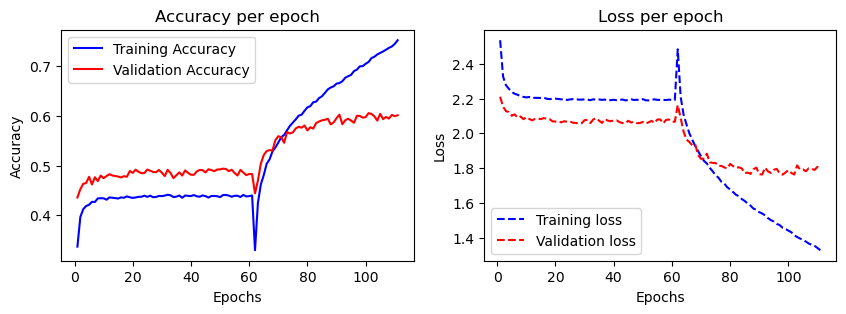

In [14]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

training_history = pd.read_csv(HIST_CSV_PATH, delimiter=",", header=0)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)

# Labels des axes
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
ax1.plot(np.arange(1, training_history["accuracy"].count() + 1, 1),
         training_history["accuracy"],
         label='Training Accuracy',
         color='blue')

# Courbe de la précision sur l'échantillon de test
ax1.plot(np.arange(1, training_history["val_accuracy"].count() + 1, 1),
         training_history['val_accuracy'],
         label='Validation Accuracy',
         color='red')

ax1.legend()
ax1.set_title("Accuracy per epoch")

ax2 = fig.add_subplot(122)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax2.plot(np.arange(1, training_history["loss"].count() + 1, 1),
         training_history['loss'],
         label='Training loss',
         linestyle="dashed",
         color='blue')

ax2.plot(np.arange(1, training_history["val_loss"].count() + 1, 1),
         training_history['val_loss'],
         label='Validation loss',
         linestyle="dashed",
         color='red')

ax2.legend()
ax2.set_title("Loss per epoch")

# Affichage de la figure
plt.show()

## Prédictions de la catégorie des images du jeu de test

In [15]:
import numpy as np
from IPython.display import clear_output

predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
    predictions = np.concatenate(
        [predictions, np.argmax(model.predict(x, verbose=0), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

clear_output(wait=True)
print("Done")

Done


## Affichage du rapport de classification

In [16]:
from sklearn import metrics

prdtypecodes = sorted([int(x) for x in os.listdir(TEST_DIR)])

test_labels = [prdtypecodes[int(i)] for i in labels]
predictions_labels = [prdtypecodes[int(i)] for i in predictions]

print("Score accuracy :", metrics.accuracy_score(
    test_labels, predictions_labels), "\n\n")
print(metrics.classification_report(test_labels, predictions_labels))

Score accuracy : 0.602802637776731 


              precision    recall  f1-score   support

          10       0.39      0.62      0.48       570
          40       0.61      0.58      0.59       536
          50       0.92      0.91      0.92       786
          60       0.59      0.22      0.32       165
        1140       0.48      0.32      0.38       958
        1160       0.35      0.16      0.22       411
        1180       0.61      0.75      0.67      1044
        1280       0.77      0.46      0.57       157
        1281       0.39      0.47      0.43       499
        1300       0.48      0.46      0.47       694
        1301       0.54      0.56      0.55      1030
        1302       0.73      0.83      0.78       889
        1320       0.73      0.47      0.57       167
        1560       0.48      0.48      0.48      1022
        1920       0.40      0.30      0.34       159
        1940       0.58      0.87      0.70       899
        2060       0.63      0.62      0.62

## Affichage de la matrice de confusion

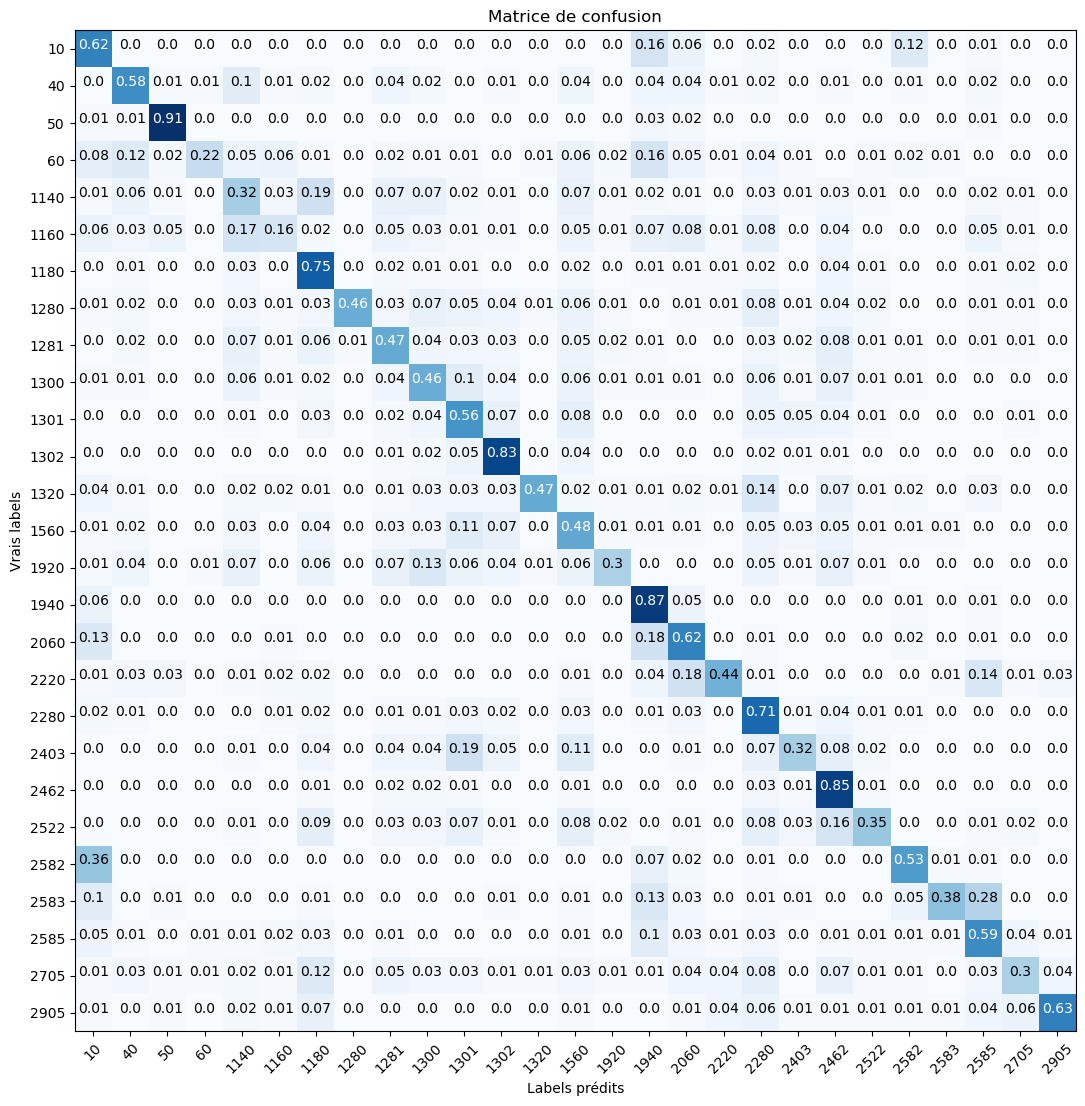

In [17]:
import itertools
from matplotlib import pyplot as plt


cnf_matrix = np.round(metrics.confusion_matrix(
    test_labels, predictions_labels, normalize="true"), 2)

classes = range(0, NO_OF_OUTPUT_CLASSES)

plt.figure(figsize=(13, 13))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
tick_marks = classes
plt.xticks(tick_marks, prdtypecodes)
plt.yticks(tick_marks, prdtypecodes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.xticks(rotation=45)
plt.show()

## Enregistrement du modèle

In [25]:
# Load the latest checkpoint to avoid overfitting
latest = latest_checkpoint(CHECKPOINT_DIR)
if (latest is not None):
    print("Loading checkpoint", latest)
    model.load_weights(latest)

# Save the model into a .h5 file
model_path = os.path.join(CHECKPOINT_DIR, "cnn_mobilenetv2.h5")
model.save(model_path)
print("Modèle enregistré à l'adresse :", model_path)

Loading checkpoint data/models/cnn_mobilenetv2_keras/cp_1.77-0.61-.ckpt
Modèle enregistré à l'adresse : data/models/cnn_mobilenetv2_keras/cnn_mobilenetv2.h5


In [26]:
from tensorflow import keras
import numpy as np
from sklearn import metrics

# Load the model, predict and display classification report to be sure we have the same results
reconstructed_model = keras.models.load_model(model_path)

predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
    predictions = np.concatenate(
        [predictions, np.argmax(reconstructed_model.predict(x, verbose=0), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

prdtypecodes = sorted([int(x) for x in os.listdir(TEST_DIR)])

test_labels = [prdtypecodes[int(i)] for i in labels]
predictions_labels = [prdtypecodes[int(i)] for i in predictions]

print("Score accuracy :", metrics.accuracy_score(
    test_labels, predictions_labels), "\n\n")
print(metrics.classification_report(test_labels, predictions_labels))

Score accuracy : 0.5985044747998116 


              precision    recall  f1-score   support

          10       0.45      0.50      0.47       570
          40       0.65      0.54      0.59       536
          50       0.91      0.92      0.91       786
          60       0.69      0.24      0.36       165
        1140       0.40      0.40      0.40       958
        1160       0.33      0.20      0.25       411
        1180       0.65      0.69      0.67      1044
        1280       0.73      0.39      0.51       157
        1281       0.39      0.42      0.40       499
        1300       0.49      0.43      0.46       694
        1301       0.56      0.51      0.54      1030
        1302       0.83      0.78      0.80       889
        1320       0.63      0.54      0.59       167
        1560       0.44      0.55      0.49      1022
        1920       0.48      0.23      0.31       159
        1940       0.69      0.81      0.74       899
        2060       0.78      0.50      0.6